In [1]:
from ramCOH.signal_processing import functions as f
import ramCOH.raman as ram
from ramCOH.signal_processing import curves as c
import numpy as np
import matplotlib.pyplot as plt
import meltInc.plotStyle as ps

ps.layout(colors=ps.colors.vitaminC)

In [2]:
import csaps as cs
from ramCOH.signal_processing import curve_fitting as cf
from ramCOH.signal_processing import deconvolution as d
import numpy as np

In [15]:
glass_file = "./glass/PI032-04-01_2021_11_15_18_23_24_532nm_Edge_100%_x100_VIS_LWD_H50_1800 (450-850nm)_150s x 2_01.txt"
x, y = np.genfromtxt(glass_file, unpack=True)
olivine_file = "./olivine/PI032-04-01_2022_03_01_15_42_56_532nm_Edge_100�_x50_VIS_LWD_H150_1800 (450-850nm)_5s x 2_01.txt"
olivine_x, olivine_y = np.genfromtxt(olivine_file, unpack=True)

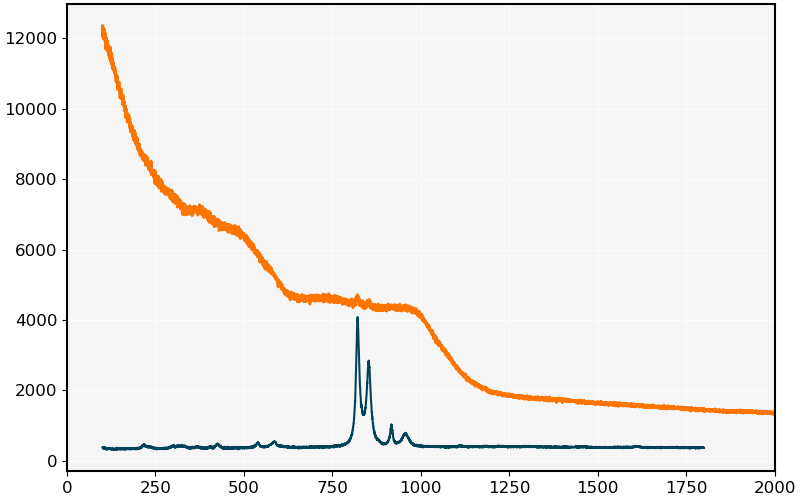

In [16]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(x, y, linewidth=2)
plt.plot(olivine_x, olivine_y, linewidth=1.5)


plt.xlim(0,2000)

plt.show()

In [17]:
# birs = np.array([[0, 250], [460,550], [625, 695], [1020, 4000]])
birs = np.array([[0, 730], [1015, 4000]])
glass = ram.H2O(x, y)
glass.extract_olivine(olivine_x, olivine_y, birs=birs, noise_threshold=3, threshold_scale=0., smooth=2e-7)

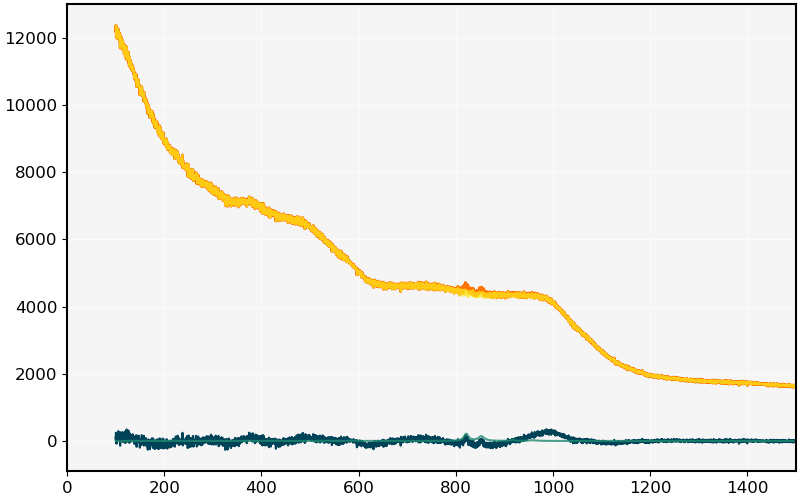

In [18]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(x, y, linewidth=2)
plt.plot(glass.x, glass.olivine_interference, linewidth=1.5)
# plt.plot(glass.x, glass.spectrum_spline, linewidth=2)
plt.plot(glass.x, glass.intensities["olivine_corrected"], linewidth=1.2, alpha=0.8)
# plt.plot(glass.x, c.sum_GaussLorentz(glass.x, *glass.olivine_main_peaks), linewidth=1.2)
plt.plot(glass.x, glass.olivine / glass.olivine_scale, linewidth=1.5, alpha=0.8)

plt.xlim(0,1500)
plt.show()

In [19]:
np.sort(glass.olivine_main_peaks[1])[-2:]


array([111.29952527, 273.74504197])

In [ ]:
birs = np.array([[0, 740], [900, 910], [1000, 4000]])
xbir, ybir = f._extractBIR(glass.x, glass.intensities["raw"], birs)
cs.csaps(xbir, ybir, 1e-6)

In [ ]:
birs = np.array([[0,740],[900,910], [1000,4000]])
xbir, ybir = f._extractBIR(glass.x, glass.intensities["raw"], birs)

In [ ]:
spline = cs.csaps(xbir, ybir, smooth=1e-6)
spectrum_spline = spline(glass.x)
olivine = glass.intensities["raw"] - spectrum_spline

In [ ]:
noise_area = (glass.x > 1250) & (glass.x < 2000)
noise = olivine[noise_area].std(axis=None)
print(noise)

In [ ]:
trim = (glass.x > 700) & (glass.x < 1400)
x_trim = glass.x[trim]
olivine_trim = olivine[trim]

In [ ]:
fit_window = 8
_, centers, widths = cf._find_peak_parameters(
            x_trim, olivine_trim, prominence=8
        )
fit_areas = cf._get_peakFit_ranges(
    centers=centers, half_widths=widths, fit_window=fit_window
)
print(fit_areas)
print(centers)

In [ ]:
noise_threshold = 3
threshold_scale = 0.1

threshold_scaler = (
            lambda y: (
                (y / olivine_trim.max() * 2 * threshold_scale) + (1 - threshold_scale)
            )
            * noise_threshold
        )

In [ ]:
peak_prominence = 8
cutoff_high = 1400

fitted_parameters = []
for area in fit_areas:
    xtrim, ytrim = cf._trimxy_ranges(x_trim, olivine_trim, area)
    noise_threshold_local = threshold_scaler(ytrim.max())
    
    parameters, *_ = d.deconvolve_signal(
        x=xtrim,
        y=ytrim,
        noise_threshold=noise_threshold_local,
        min_amplitude=6,
        min_peak_width=6,
        prominence=2,
        noise=noise,
        max_iterations=3,
        baseline0=True
    )
    fitted_parameters.append(parameters)

deconvolution_parameters = []
for parameter in zip(*fitted_parameters):
    deconvolution_parameters.append(np.concatenate(parameter))

print(deconvolution_parameters)

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(x, y, linewidth=2)
# plt.plot(glass.x, spectrum_spline)
plt.plot(glass.x, glass.olivine)
plt.plot(glass.x, c.sum_GaussLorentz(glass.x, *deconvolution_parameters))


plt.xlim(0,2000)
plt.ylim(-500,7e3)

plt.show()

In [ ]:
prominence = 8

amplitudes, centers, widths = cf._find_peak_parameters(
            glass.x, olivine, prominence= prominence
        )

print(amplitudes, centers, widths)

In [ ]:
cf._get_peakFit_ranges(centers, widths, fit_window=8)

In [ ]:
glass.olivine_main_peaks